Load the LLM

In [1]:
from langchain_community.llms.mlx_pipeline import MLXPipeline
from langchain_community.chat_models.mlx import ChatMLX
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.globals import set_verbose
from langchain.globals import set_debug

#set_debug(True)
set_verbose(True)

print('Loading model...')
# Load model from huggingface, using the MLX framework to take advantage of Apple Silicon
llm = MLXPipeline.from_model_id(
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-8bit",
    #"mlx-community/Meta-Llama-3.1-8B-Instruct-bf16",
    "mlx-community/Qwen2.5-32B-Instruct-4bit", # Let's try using a larger model, see if that improves results
    #"mlx-community/Llama-3.2-3B-Instruct-8bit",
    pipeline_kwargs={"max_tokens": 2048, "temp": 0.2, "repetition_penalty":1.2},
)

# Setup verbose mode: https://stackoverflow.com/a/77629872/10914628
model = ChatMLX(llm=llm).with_config({'callbacks': [ConsoleCallbackHandler()]})
print('Model loaded.')


Loading model...


/Users/frieder/Documents/GitHub/procedural-stories/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 12 files: 100%|██████████| 12/12 [05:17<00:00, 26.43s/it]


Model loaded.


Load the ontology

In [2]:
from generator.utils.serializers import json2llmready

print('Loading ontology...')
with open("story.json", "r") as f:
    ontology = json2llmready(f.read())
print(ontology)

Loading ontology...
[{'ID': 'containsCharacter', 'Type': ['ObjectProperty'], 'Domain': 'Location', 'Range': 'Character', 'InverseOf': 'isAtLocation'}, {'ID': 'performedByCharacter', 'Type': ['ObjectProperty'], 'Domain': 'Action', 'Range': 'Character'}, {'ID': 'Character', 'Type': ['Class'], 'Label': 'Personnage'}, {'ID': 'isFactionMember', 'Type': ['ObjectProperty'], 'Domain': 'Character', 'Range': 'Faction', 'InverseOf': 'hasMember'}, {'ID': 'http://www.florianrieder.com/story.owl', 'Type': ['Ontology']}, {'ID': 'Player', 'Type': ['Class'], 'Label': 'Joueur'}, {'ID': 'Condition', 'Type': ['Class']}, {'ID': 'isControlledByFaction', 'Type': ['ObjectProperty'], 'Domain': 'Location', 'Range': 'Faction', 'InverseOf': 'hasControlOfLocation'}, {'ID': 'hasGoal', 'Type': ['ObjectProperty'], 'Domain': 'Entity', 'Range': 'Goal'}, {'ID': 'Action', 'Type': ['Class'], 'Label': 'Action', 'Comment': 'Une action que peut prendre un personnage'}, {'ID': 'hasRole', 'Type': ['ObjectProperty'], 'Domain': 

Define the setting of the story

In [57]:
setting = "Normandie viking du 9e siècle"

# 1. Generate the outline of the story world

In [58]:
OUTLINE_TEXT_PROMPT = """
You are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.
Write a few paragraphs describing the world of the story following the given narrative setting:

{{ setting }}

Your text should be quite short, concise and descriptive.
Your staff will use this text as the story world bible, they will write the characters, locations and specific events.
You should direct them as precisely as possible to create as coherent and unified world for the player to explore.
Define the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.
Write your output in {{ language }}.
"""

In [59]:
language = "french"

prompt = PromptTemplate(
    input_variables=['setting', 'language'],
    template=OUTLINE_TEXT_PROMPT,
    template_format='jinja2'
)

chain = prompt | model

outline_text = chain.invoke({'setting': setting, 'language': language})

outline_text

Parent run 02c16981-f4d0-4dad-a35d-ab3eeaeec5ad not found for run b24c467c-68d0-4c99-ad86-13f1565db73c. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nYou are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.\nWrite a few paragraphs describing the world of the story following the given narrative setting:\n\nNormandie viking du 9e siècle\n\nYour text should be quite short, concise and descriptive.\nYour staff will use this text as the story world bible, they will write the characters, locations and specific events.\nYou should direct them as precisely as possible to create as coherent and unified world for the player to explore.\nDefine the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.\nWrite your output in french."
  ]
}
[llm/end] [llm:ChatMLX] [102.43s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Dans le monde des Normands du IXème siècle, la société est dominée par les guerriers et naviga

AIMessage(content="Dans le monde des Normands du IXème siècle, la société est dominée par les guerriers et navigateurs intrépides qui ont établi leur puissance sur les vastes mers d'Europe. Les terres sont parsemées de villages fortifiés entourés de haies épines pour protéger contre les raids ennemis. La culture se caractérise par une foi profonde dans l'honneur martial et un respect inné pour Odin, Thor et Freya.\n\nLe joueur incarne un jeune Viking ambitieux cherchant à prouver sa valeur en accomplissant des quêtes héroïques. Son objectif principal consiste à rassembler suffisamment de richesses et de renommée pour fonder son propre clan ou rejoindre celui d'un chef réputé. Le conflit central tournera autour des rivalités entre clans locaux et des attaques constantes des forces extérieures qui menacent la sécurité et la prospérité des communautés normandes. \n\nLes personnages seront imprégnés de valeurs comme la bravoure, mais aussi confrontés aux réalités cruelles de cette ère où l

In [30]:
print(outline_text.content)

Bienvenue dans le monde des Vikings de Normandie au IXème siècle. Ce royaume est un mélange d'histoire et de légendes où la mer sert à la fois comme voie vers l'inconnu et comme frontière protectrice contre les envahisseurs. Les terres sont fertiles mais difficiles, couvertes parfois de vastes forêts aux mystères innombrables.

Le joueur incarnera un jeune guerrier ou une jeune guerrière Viking qui aspire à gagner honneur et richesse en explorant ces contrées lointaines et menacées. Le personnage doit naviguer entre alliances tribales instables et conflits internationaux naissants pour prouver sa valeur face aux autres clans et protéger son peuple des dangers extérieurs et intérieurs.

La quête principale consiste à rassembler les artefacts sacrés dispersés sur plusieurs îles afin de renforcer leur clan avant que ne survienne une menace commune plus grande encore : une invasion présumée d'une puissance étrangère redoutable. Chaque décision prise aura des répercussions immenses sur le d

# 2. Generate locations

In [63]:
LOCATIONS_GENERATION_PROMPT = """
You are the master world writer for an interactive fiction.
On the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.
Define at least 4 to 5 main locations, as well as intermediate locations if pertinent.
Your staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !
You must take utmost care in creating a logical topology with no islands and coherent connections.
Always refer to other locations using their "name" property in the links ! You should define all locations mentioned in the links.

Output your work in the following JSON format:
```json
    "Locations": [
        {
            "name": "Gravepine",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Chateau"]
        },
        {
            "name": "Chateau",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Gravepine", "Nom d'un autre lieu"]
        },
        ...
    ],
```

Narrative context:
{{ context }}

Your output JSON values should always be in {{ language }}
"""

In [66]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

from generator.parsers import OutlineParser

prompt = PromptTemplate(
    input_variables=['setting'],
    template=LOCATIONS_GENERATION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser() # OutlineParser

chain = prompt | model | parser

locations_output = chain.invoke({'context': outline_text.content, 'language': language})


Parent run 721b4a81-a65c-441f-b014-d8b69c2e2295 not found for run 00c33967-236f-474e-b03e-5e73c91a66e2. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \nYou are the master world writer for an interactive fiction.\nOn the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.\nDefine at least 4 to 5 main locations, as well as intermediate locations if pertinent.\nYour staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !\nYou must take utmost care in creating a logical topology with no islands and coherent connections.\nAlways refer to other locations using their \"name\" property in the links ! You should define all locations mentioned in the links.\n\nOutput your work in the following JSON format:\n```json\n    \"Locations\": [\n        {\n            \"name\": \"Gravepine\",\n            \"importance\": \"Either 'major' or 'minor', this annotation will influence how your staff will detail the\"\n           

In [70]:
location_outlines = locations_output['Locations']
location_outlines

[{'name': 'Village Fortifié de Gravepine',
  'importance': 'major',
  'description': "Ce village fortifié est situé près d'une baie stratégique, offrant un abri sûr pour les navires vikings lorsqu'ils rentrent après leurs expéditions lointaines. Entouré de haies d'épines et doté d'une muraille solide, il sert également de centre administratif local sous la protection d’un jarl respecté.",
  'links': ['Forêt Sombre', 'Port Marchand', 'Colline Sacrée']},
 {'name': 'Forêt Sombre',
  'importance': 'minor',
  'description': 'Une étendue sombre et mystérieuse peuplée de créatures légendaires selon les histoires locales. Elle offre refuge et ressources naturelles essentielles pour le village voisin, mais reste dangereuse sans guide compétent.',
  'links': ['Village Fortifié de Gravepine', 'Grottes Anciennes']},
 {'name': 'Port Marchand',
  'importance': 'major',
  'description': "Un port animé où les commerçants viennent négocier des marchandises précieuses venues des quatre coins de l’Europe

In [35]:
from dataclasses import dataclass, field
from typing import Optional, List

@dataclass
class LocationData:
    name: str
    description: str
    stance: Optional[str] = None
    relationships: Optional[List[str]] = field(default_factory=list)
    characters: Optional[List[str]] = field(default_factory=list)
    items: Optional[List[dict]] = field(default_factory=list)

In [71]:
# Encoder les lieux sous forme d'objets
locations = []
for loc in location_outlines:
    location = LocationData(name=loc['name'], description=loc['description'], relationships=loc['links'])
    print(location)
    locations.append(location)

LocationData(name='Village Fortifié de Gravepine', description="Ce village fortifié est situé près d'une baie stratégique, offrant un abri sûr pour les navires vikings lorsqu'ils rentrent après leurs expéditions lointaines. Entouré de haies d'épines et doté d'une muraille solide, il sert également de centre administratif local sous la protection d’un jarl respecté.", stance=None, relationships=['Forêt Sombre', 'Port Marchand', 'Colline Sacrée'], characters=[], items=[])
LocationData(name='Forêt Sombre', description='Une étendue sombre et mystérieuse peuplée de créatures légendaires selon les histoires locales. Elle offre refuge et ressources naturelles essentielles pour le village voisin, mais reste dangereuse sans guide compétent.', stance=None, relationships=['Village Fortifié de Gravepine', 'Grottes Anciennes'], characters=[], items=[])
LocationData(name='Port Marchand', description="Un port animé où les commerçants viennent négocier des marchandises précieuses venues des quatre coi

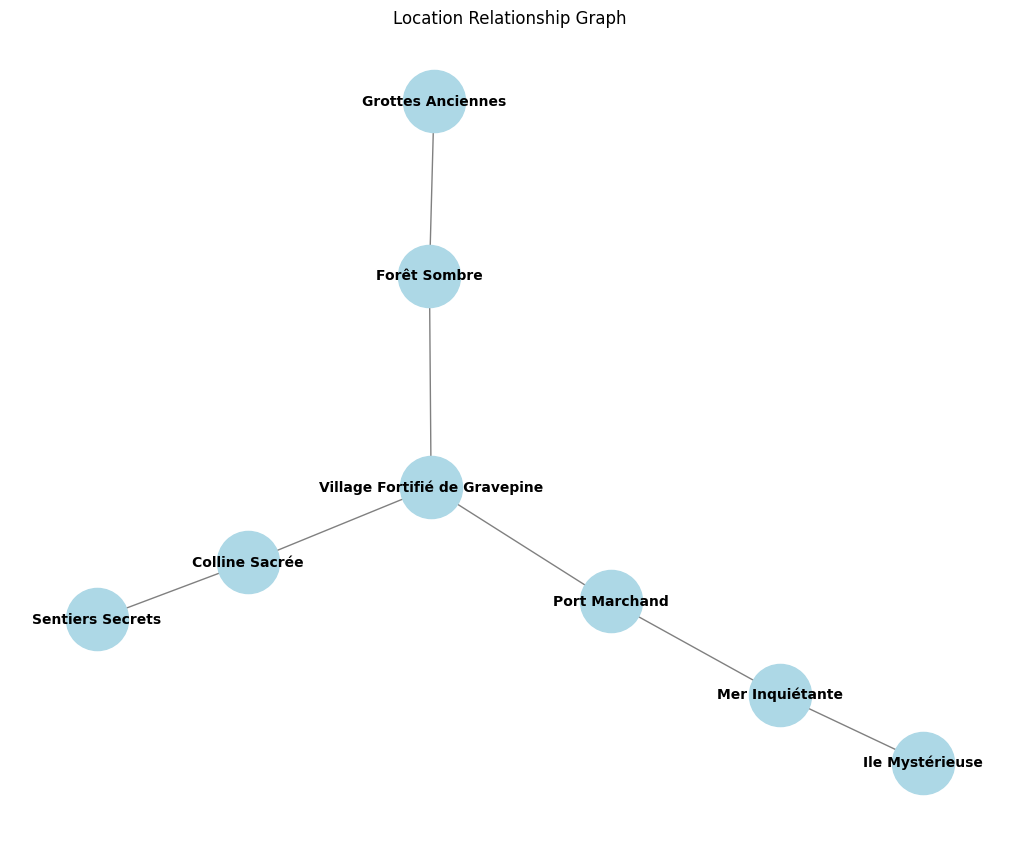

In [69]:
import networkx as nx
import matplotlib.pyplot as plt

def display_location_relationships(locations: List[LocationData]):
    # Create a graph
    G = nx.Graph()

    # Add nodes and edges
    for location in locations:
        G.add_node(location.name)  # Add each location as a node
        for related_location in location.relationships:
            # Create edges for relationships
            G.add_edge(location.name, related_location)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # Positioning of the graph

    # Draw nodes, edges, and labels
    nx.draw(G, pos,
            with_labels=True,
            node_color='lightblue',
            node_size=2000,
            font_size=10,
            font_weight='bold',
            edge_color='gray')
    plt.title('Location Relationship Graph')
    plt.show()

display_location_relationships(locs)

Structure works, it's a hub structure with linear branches. Good enough !
Extra points for the water structure

In [31]:
STORY_OUTLINE_PROMPT = """
# Instructions pour la génération
Sur la base du contexte narratif ci-dessous, générez les grandes lignes d'une histoire possible en tenant compte des éléments suivants :

    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.
    Personnages: Etablir une liste d'au moins **4 à 6** personnages principaux de l'histoire, sans rentrer dans trop de détails. Veille à établir au moins un antagoniste principal.
    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif qui motive l'action.
    Événements : Décrire au moins 1 à 3 événements clés qui alimentent l'histoire et doivent être déclenchés par l'action du joueur.
    Objets : Générer uniquement les éléments essentiels nécessaires pour compléter l'histoire (objets de quête), en incluant : Un nom et une description de chaque objet, avec sa fonction dans le récit. Indiquer le lieu où se trouve chaque objet, en s'assurant qu'il s'intègre logiquement dans le contexte de l'histoire.
    Commentaires : Inclure tout commentaire supplémentaire qui pourrait guider la génération de détails supplémentaires ou éclaircir des éléments importants de l'histoire.

# Format de sortie
D'abord, raisonner sur le contexte narratif donné et son importance pour la cohérence du monde et de l'histoire, l'intrigue principale (qui doit être de nature ouverte), et les relations des personnages.
Fournir les éléments dans un fichier json structuré selon le format suivant:
{
    "Player": {
        "name": "Donner le nom du personnage qu'incarne le joueur",
        "description": "Description en quelques phrases du personnage qu'incarne le joueur",
        "location": "Nom du lieu de départ de l'histoire"
    },
    "Characters": [
        {
            "name": "Nom propre du personnage 1",
            "description": "description en une phrase du personnage, incorporant son rôle et sa fonction dans l'histoire, et sa relation aux autres personnages.",
        },
        ...
    ],
    "Goal": {
        "description": "description du problème ou de l'enjeu qui motive le joueur"
        "requiresItem": "(FACULTATIF) S'il un objet qui est le centre de l'histoire et doit être récupéré pour gagner, l'indiquer ici. Sinon, omettre ce champs."
    },
    "Events": [
        {
            "name": "Evènement 1",
            "description": "description de l'évènement",
            "condition": "description de la condition qui déclenche l'évènement (devrait être déclenché par l'action du joueur !)",
            "consequences": ["Une ou plusieurs conséquences à l'évènement", "deuxième conséquence possible"]
        },
        ...
    ],
    "Items": [
        {
            "name": "Nom de l'objet",
            "description": "description courte de l'objet et de sa fonction dans le récit",
            "location": "(OBLIGATOIRE) Nom du lieu qui contient l'objet"
        },
        ...
    ],
    "Comments": [
        "Tout commentaire que tu voudrais ajouter pour guider la génération de détails supplémentaires et pendant le jeu. Sois précis plus que général: donne des commentaires qui peuvent être exploités. Des éléments importants de l'histoire"
    ]
}

# Contexte narratif
{{ setting }}



# Résultat
"""

In [33]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

from generator.parsers import OutlineParser

prompt = PromptTemplate(
    input_variables=['setting'],
    template=OUTLINE_GENERATION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser() # OutlineParser

chain = prompt | model | parser

outline = chain.invoke({'setting': outline_text.content})



Parent run df462d12-8ef2-494d-8074-4a93113b793d not found for run 60aec6f8-e637-4d27-b1c6-84378bf16969. Treating as a root run.


[llm/start] [llm:ChatMLX] Entering LLM run with input:
{
  "prompts": [
    "Human: \n# Instructions pour la génération\nSur la base du contexte narratif ci-dessous, générez les grandes lignes d'une histoire possible en tenant compte des éléments suivants :\n\n    Lieux : Définissez au moins **4 à 5** lieux clés pertinents pour le contexte et la construction du monde. Incluez une description succincte de chaque lieu.\n    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.\n    Personnages: Etablir une liste d'au moins **4 à 6** personnages principaux de l'histoire, sans rentrer dans trop de détails. Veille à établir au moins un antagoniste principal.\n    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif qui motive l'action.\n    Événements : Décr

In [ ]:
outline

In [ ]:

# prompt = PromptTemplate(
#     input_variables=["setting", "location", "characters", "items"],
#     template=LOCATION_EXPANSION_PROMPT,
#     template_format='jinja2'
# )

# parser = JsonOutputParser()

# chain = prompt | model | parser

# for location in outline.locations:

#     res = chain.invoke({"setting": setting,
#                         "location": location,
#                         "characters": outline.characters,
#                         "items": outline.items })

#     print('----*----')
#     print(res)
#     print('----*----')